In [ ]:
'''
Code provided by Philippine Space Agency on March 15 to 17 2023
plotting section edited by S Visaga
to use cartopy instead of basemap
'''


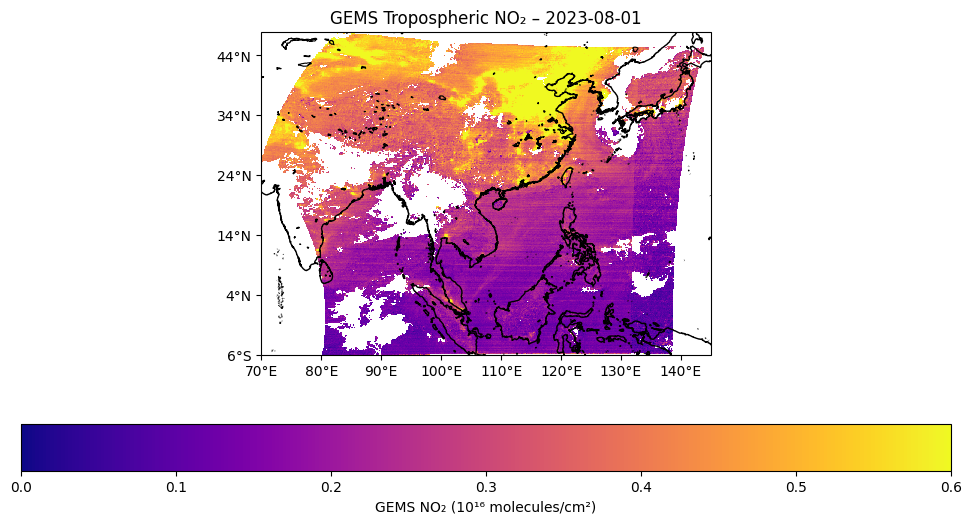

In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Functions for map styling
def plot_background(ax):
    ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
    return ax

def plot_ticks(ax, lon_min, lon_max, lat_min, lat_max):
    ax.set_xticks(np.arange(np.floor(lon_min), np.ceil(lon_max)+1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.floor(lat_min), np.ceil(lat_max)+1, 10), crs=ccrs.PlateCarree())

    lon_formatter = LongitudeFormatter(number_format='.0f', degree_symbol='°', dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f', degree_symbol='°')

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    return ax

# --- Load GEMS file (example date: August 1, 2023) ---
file = "/ships22/raqms/Satellite/GEMS/L3/NO2/GK2_GEMS_L3_20230809_NO2_GRID-EA_daily_010.nc"
f = netCDF4.Dataset(file)

# --- Extract variables ---
no2_raw = f.groups['Data Fields'].variables['ColumnAmountNO2'][:]  # shape: (time, lat, lon)
lat = f.groups['Geolocation Fields'].variables['Latitude'][:]
lon = f.groups['Geolocation Fields'].variables['Longitude'][:]

# --- Unit conversion: molec/cm² → 10¹⁶ molec/cm² ---
no2 = no2_raw / 1e16

# --- Set plotting bounds from lat/lon ---
lon_min = lon.min()
lon_max = lon.max()
lat_min = lat.min()
lat_max = lat.max()

# --- Plot ---
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
plot_background(ax)
plot_ticks(ax, lon_min, lon_max, lat_min, lat_max)

mesh = ax.pcolormesh(lon, lat, no2, transform=ccrs.PlateCarree(),
                     cmap="plasma", vmin=0, vmax=0.6)

plt.colorbar(mesh, orientation='horizontal', label='GEMS NO₂ (10¹⁶ molecules/cm²)')
ax.set_title("GEMS Tropospheric NO₂ – 2023-08-01")
plt.show()


In [2]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# --------- Helper Functions ---------
def plot_background(ax):
    ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
    ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
    return ax

def plot_ticks(ax, lon_min, lon_max, lat_min, lat_max):
    ax.set_xticks(np.arange(np.floor(lon_min), np.ceil(lon_max) + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.floor(lat_min), np.ceil(lat_max) + 1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))
    return ax

# --------- File Loop Setup ---------
files = sorted(glob.glob("/ships22/raqms/Satellite/GEMS/L3/NO2/*.nc"))
output_dir = "NO2_Figures_Clean"
os.makedirs(output_dir, exist_ok=True)

for f in files:
    try:
        print("Processing:", os.path.basename(f))
        src = netCDF4.Dataset(f)

        # Extract data
        no2 = np.array(src.groups['Data Fields'].variables['ColumnAmountNO2'][:])
        lat = np.array(src.groups['Geolocation Fields'].variables['Latitude'][:])
        lon = np.array(src.groups['Geolocation Fields'].variables['Longitude'][:])

        # Get and apply fill value
        fv = src.groups['Data Fields'].variables['ColumnAmountNO2'].getncattr('_FillValue') if '_FillValue' in src.groups['Data Fields'].variables['ColumnAmountNO2'].ncattrs() else -9999
        no2 = np.where(no2 == fv, np.nan, no2 / 1e16)  # convert to 1e16 molec/cm²

        # Get bounds
        lon_min, lon_max = lon.min(), lon.max()
        lat_min, lat_max = lat.min(), lat.max()

        # Extract date string from filename
        filename = os.path.basename(f)
        date_str = filename.split('_')[3]  # e.g., "20230809"
        title_date = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"  # → "2023-08-09"

        # Plot
        fig = plt.figure(figsize=(10, 6), dpi=150)
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        plot_background(ax)
        plot_ticks(ax, lon_min, lon_max, lat_min, lat_max)

        mesh = ax.pcolormesh(lon, lat, no2, transform=ccrs.PlateCarree(),
                             cmap='gist_stern_r', vmin=0, vmax=3)

        plt.colorbar(mesh, orientation='horizontal',
                     label='Column Amount NO₂ (10¹⁶ molecules/cm²)', fraction=0.046, pad=0.1)
        ax.set_title(f"GEMS Total Column NO₂ – {title_date}")
        plt.savefig(f"{output_dir}/NO2_{date_str}.png", facecolor='white', bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Skipping {f} due to error: {e}")


Processing: GK2_GEMS_L3_20230802_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230803_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230804_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230805_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230806_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230807_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230808_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230809_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230810_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230811_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230812_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230813_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230814_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230815_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230816_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230817_NO2_GRID-EA_daily_010.nc
Processing: GK2_GEMS_L3_20230818_NO2_GRID-EA_daily_010.nc
Processing: GK

In [3]:
print(no2.shape)

(540, 750)
